## Notebook description: *Coconatfly_aPhN_PhN_Cosine.ipynb*
This notebook performs a **clustering analysis of aPhN/PhN pharyngeal sensory axons** using the **FlyWire connectome** via the `coconatfly` R package (workflow adapted from *McKim et al. 2024*).

New coconatfly users should start with the coconatfly tutorial https://github.com/natverse/coconatfly/

### What it does (high-level)
1. **Loads curated neuron lists / annotations** from project CSV files in `PATH_input`.
2. **Defines a target population** of apharyngeal/pharyngeal/ sensory neurons (root IDs), then retrieves **FlyWire metadata** for those neurons.
3. **Computes output connectivity partners** (postsynaptic targets) for each neuron, applying a **synapse threshold** (e.g., ≥5) to focus on stronger connections.
4. Builds a connectivity-based representation and computes **pairwise cosine similarity** of output profiles.
5. Uses **hierarchical clustering** (Ward.D2) to group neurons by similarity of their downstream connectivity.
6. Produces a **dendrogram** with labels combining neuron ID and “nerve” annotation, saving figures to **PDF** and **SVG**, and also plotting inline.

### Key inputs
- `aPhN_PhN_v1.0*.csv`: curated/annotated list of aPhN/PhN neurons (includes `id` and annotations like `nerve`).
- A manually provided list of FlyWire **root IDs** (`ids_string`) used to query metadata/connectivity.

### Key intermediate objects
- `PanPharyngeal`: metadata table for the selected neurons (joined with annotations).
- `PanPharyngeal_partners`: partner table from `cf_partners(..., partners="outputs")`.
- `hc`: hierarchical clustering result returned by `cf_cosine_plot(..., heatmap=FALSE)`.
- `PanPharyngeal_meta`: metadata + cluster labels derived from `hc`.

### Key outputs
- Dendrogram saved to:
  - `aPhN_PhN_dendrogram_wardd2.pdf`
  - `aPhN_PhN_dendrogram_wardd2.svg`
- Inline dendrogram plots in the notebook for quick inspection.

### Notes / assumptions
- Connectivity is analyzed on **output synapses** (presynaptic neuron → downstream targets).
- Thresholds (e.g., partner threshold and cosine threshold) affect which neurons/partners contribute to similarity and clustering.
- In FlyWire FAFB v783, aPhN = Accessory pharyngeal/aPharyngeal Nerve; PhN = Pharyngeal Nerve. In this analysis, the PhN consists of the stomodeal nerve (StN) and the Dorsal Cibarial Sensory Organ (DCSO), and pharyngeal nerve motor neurons (which are not included); the aPhN consists of axons of the Ventral Cibarial Sensory Organ (VCSO) and the Labral Sensory Organ (LSO). We consider the aPhN and PhN collectively as the PanPharyngeal sensory axons.

In [ ]:
# Quick notebook summary (prints what exists in the current kernel)
summary_info <- list(
  paths = list(input = PATH_input, output = PATH_output),
  n_input_files = length(input_files),
  objects_present = c(
    aPhN_PhN = exists("aPhN_PhN"),
    PanPharyngeal = exists("PanPharyngeal"),
    PanPharyngeal_partners = exists("PanPharyngeal_partners"),
    hc = exists("hc"),
    PanPharyngeal_meta = exists("PanPharyngeal_meta")
  ),
  counts = list(
    aPhN_PhN_rows = if (exists("aPhN_PhN")) nrow(aPhN_PhN) else NA_integer_,
    PanPharyngeal_rows = if (exists("PanPharyngeal")) nrow(PanPharyngeal) else NA_integer_,
    PanPharyngeal_meta_rows = if (exists("PanPharyngeal_meta")) nrow(PanPharyngeal_meta) else NA_integer_
  )
)

print(summary_info)

## Output files produced by this notebook
If `PATH_output` points to a writable directory, running the plotting cells will write:
- `aPhN_PhN_dendrogram_wardd2.pdf`
- `aPhN_PhN_dendrogram_wardd2.svg`

These contain the hierarchical clustering dendrogram of the selected PanPharyngeal neuron population based on cosine similarity of **output connectivity**.


In [41]:
#----Figure_1D-------------------------------------------------------------------
#-------------------------------------------------------------------------------
# This is the code for aPhN/PhN clustering analysis, adapted from McKim et al. 2024
#-------------------------------------------------------------------------------

#-load packages-----------------------------------------------------------------
library(tidyverse)
library(coconatfly)

###general variables:-----------------------------------------------------------
set.seed(42)
options(scipen=999)

PATH_input = "./Giakoumas-et-al/input/input_coconatfly/"
PATH_output = "./Giakoumas-et-al/input/input_coconatfly/"
version <- "1.0"  # Specify version manually

In [ ]:
# List filenames in PATH_input (top-level only; no subfolders).
input_files = list.files(path=PATH_input, full.names = FALSE, recursive = FALSE)

# List filenames in the PATH_input/tmp subfolder (top-level only).
input_files_tmp = list.files(path=paste0(PATH_input, "tmp/"),
                             full.names = FALSE, recursive = FALSE)

input_files = c(input_files, input_files_tmp)
v = read_delim(paste0(PATH_input, "aPhN_PhN_v1.0.csv"),
               col_types=cols(version=col_character()), delim=";")

v = v$version[1]

# set variables:----------------------------------------------------------------
aPhN_PhN = read_delim(paste0(PATH_input, "aPhN_PhN_v1.0", v, ".csv"),
                  col_types=cols(root_id=col_character()), delim=",")
#-------------------------------------------------------------------------------
#clustering of all PanPharyngeal axons
colnames(aPhN_PhN)[1] <- 'id'
# paste0(aPhN_PhNid, collapse = ",")

# obtain meta data for all a/pharyngeal cells


In [43]:
# obtain root ids for all a/pharyngeal from FlyWire or from .csv input file
ids_string <- paste(c(
"720575940627219272", "720575940625173006", "720575940622406694", "720575940623458633",
    "720575940612819763", "720575940635005303", "720575940633660314", "720575940634667234",
    "720575940611351193", "720575940610103906", "720575940617668662", "720575940621848781",
    "720575940624186602", "720575940640611803", "720575940630734393", "720575940618156315",
    "720575940635739504", "720575940620885342", "720575940629972215", "720575940638054197",
    "720575940620575579", "720575940616791067", "720575940615879995", "720575940630597177",
    "720575940607152476", "720575940620699162", "720575940631205580", "720575940626767152",
    "720575940606239666", "720575940645108936", "720575940634085786", "720575940619652033",
    "720575940648377209", "720575940644676900", "720575940627989609", "720575940627274578",
    "720575940612256938", "720575940621207517", "720575940630654539", "720575940633194029",
    "720575940623056422", "720575940620983637", "720575940622144648", "720575940611388595",
    "720575940633129171", "720575940650760825", "720575940646039092", "720575940633895469",
    "720575940625941022", "720575940633129683", "720575940631572141", "720575940607166731",
    "720575940637896245", "720575940631070239", "720575940653233569", "720575940639786830",
    "720575940613347474", "720575940633759840", "720575940620528990", "720575940632743649",
    "720575940638086256", "720575940630574659", "720575940622198772", "720575940633579360",
    "720575940624724458", "720575940624502269", "720575940631963821", "720575940631049064",
    "720575940606163842", "720575940614641202", "720575940623951591", "720575940638357813",
    "720575940611959011", "720575940625871181", "720575940620910716", "720575940626311049",
    "720575940624905572", "720575940645493283", "720575940626396803", "720575940624910373",
    "720575940617034713", "720575940604355872", "720575940621106465", "720575940632040749",
    "720575940630434616", "720575940625785731", "720575940629887695", "720575940622575754",
    "720575940612642730", "720575940622606106", "720575940611056482", "720575940636943849",
    "720575940636542565", "720575940618889931", "720575940611630194", "720575940640554045",
    "720575940632596449", "720575940616934289", "720575940637019994", "720575940613004402",
    "720575940605682790", "720575940627107271", "720575940631462969", "720575940605161388",
    "720575940639972816", "720575940630806267", "720575940659479937", "720575940626520402",
    "720575940628344074", "720575940611643033", "720575940616196539", "720575940634826135",
    "720575940609787256", "720575940615015976", "720575940625972261", "720575940623511795",
    "720575940655071905", "720575940629112887", "720575940616308921", "720575940631069255",
    "720575940628891774", "720575940611168921", "720575940610259406", "720575940626014218",
    "720575940621916952", "720575940624266061", "720575940622346180", "720575940626015242",
    "720575940617828766", "720575940629009468", "720575940625032548", "720575940625163790",
    "720575940628329546", "720575940635391845", "720575940632423394", "720575940621870349",
    "720575940618788944", "720575940633165980", "720575940616616861", "720575940633791935",
    "720575940638419534", "720575940623660558", "720575940630893196", "720575940611211417",
    "720575940627454569", "720575940658442625", "720575940609913042", "720575940640601563",
    "720575940637130985", "720575940619928929", "720575940610981362", "720575940614830239",
    "720575940617121819", "720575940625031610", "720575940621689880", "720575940628131778",
    "720575940623834300", "720575940626983952", "720575940626217226", "720575940629358807",
    "720575940622199593", "720575940624948867", "720575940637165028", "720575940631284511",
    "720575940628673474", "720575940616562150", "720575940638608803"
),
    collapse = " ")

In [44]:
# Now, retrieve metadata for all root IDs using the concatenated string
PanPharyngeal <- cf_meta(cf_ids(ids_string, datasets = "flywire"))

In [45]:
PanPharyngeal = left_join(PanPharyngeal,aPhN_PhN,by = "id")
PanPharyngeal$side_name_id = paste(
PanPharyngeal$side,
PanPharyngeal$name,PanPharyngeal$id,sep="")

In [46]:
library(bit64)

PanPharyngeal_partners <- PanPharyngeal %>%
cf_partners(
threshold = 5,        # Minimum synapse count
partners = "outputs"  # Focus on output synapses
)

# 4. Aggregate synapse counts per neuron
output_counts <- PanPharyngeal_partners %>%
group_by(pre_id) %>%
summarise(output_count = sum(weight))

# 5. Convert pre_id to character for compatibility
output_counts <- output_counts %>%
mutate(pre_id = as.character(pre_id))

# 6. Join counts back to metadata
PanPharyngeal <- PanPharyngeal %>%
left_join(output_counts, by = c("id" = "pre_id")) %>%
filter(output_count >= 5)

###PanPharyngeal Dendrogram Workflow

In [69]:
library(tidyverse)
library(coconatfly)
library(glue)

# Rename first column to 'id'
colnames(aPhN_PhN)[1] <- 'id'

# Retrieve metadata for all pharyngeal cells using the connectivity matrix (PanPharyngeal$key)
hc <- cf_cosine_plot(
    PanPharyngeal$key,
threshold = 1,
partners = "outputs",
method = "ward.D2",
heatmap = FALSE  # do not plot; return hclust
)

PanPharyngeal_meta <- cf_meta(hc)
PanPharyngeal_meta <- coconat::add_cluster_info(PanPharyngeal_meta, hc, h = 0.75, idcol = 'key')



Warning message in coconat::partner_summary2adjacency_matrix(x[["outputs"]], inputcol = "pre_key", :
“Dropping: 1084/14017 neurons representing 5684/101142 synapses due to missing ids!”


In [70]:
# Create combined labels: "id: nerve"
combined_labels <- paste(PanPharyngeal_meta$id, PanPharyngeal_meta$nerve, sep="_")

# Save to PDF with adjusted margins to prevent clipping of labels
pdf(paste0(PATH_output, "aPhN_PhN_dendrogram_wardd2.pdf"), width = 10, height = 6)
par(mar = c(15, 5, 4, 5), xpd = TRUE)
plot(hc,
     labels = combined_labels,
     hang = -0.01,
     cex = 0.3,
     main = "PanPharyngeal Sensory Axons Dendrogram")
dev.off()

pdf 
  2

null device 
          1

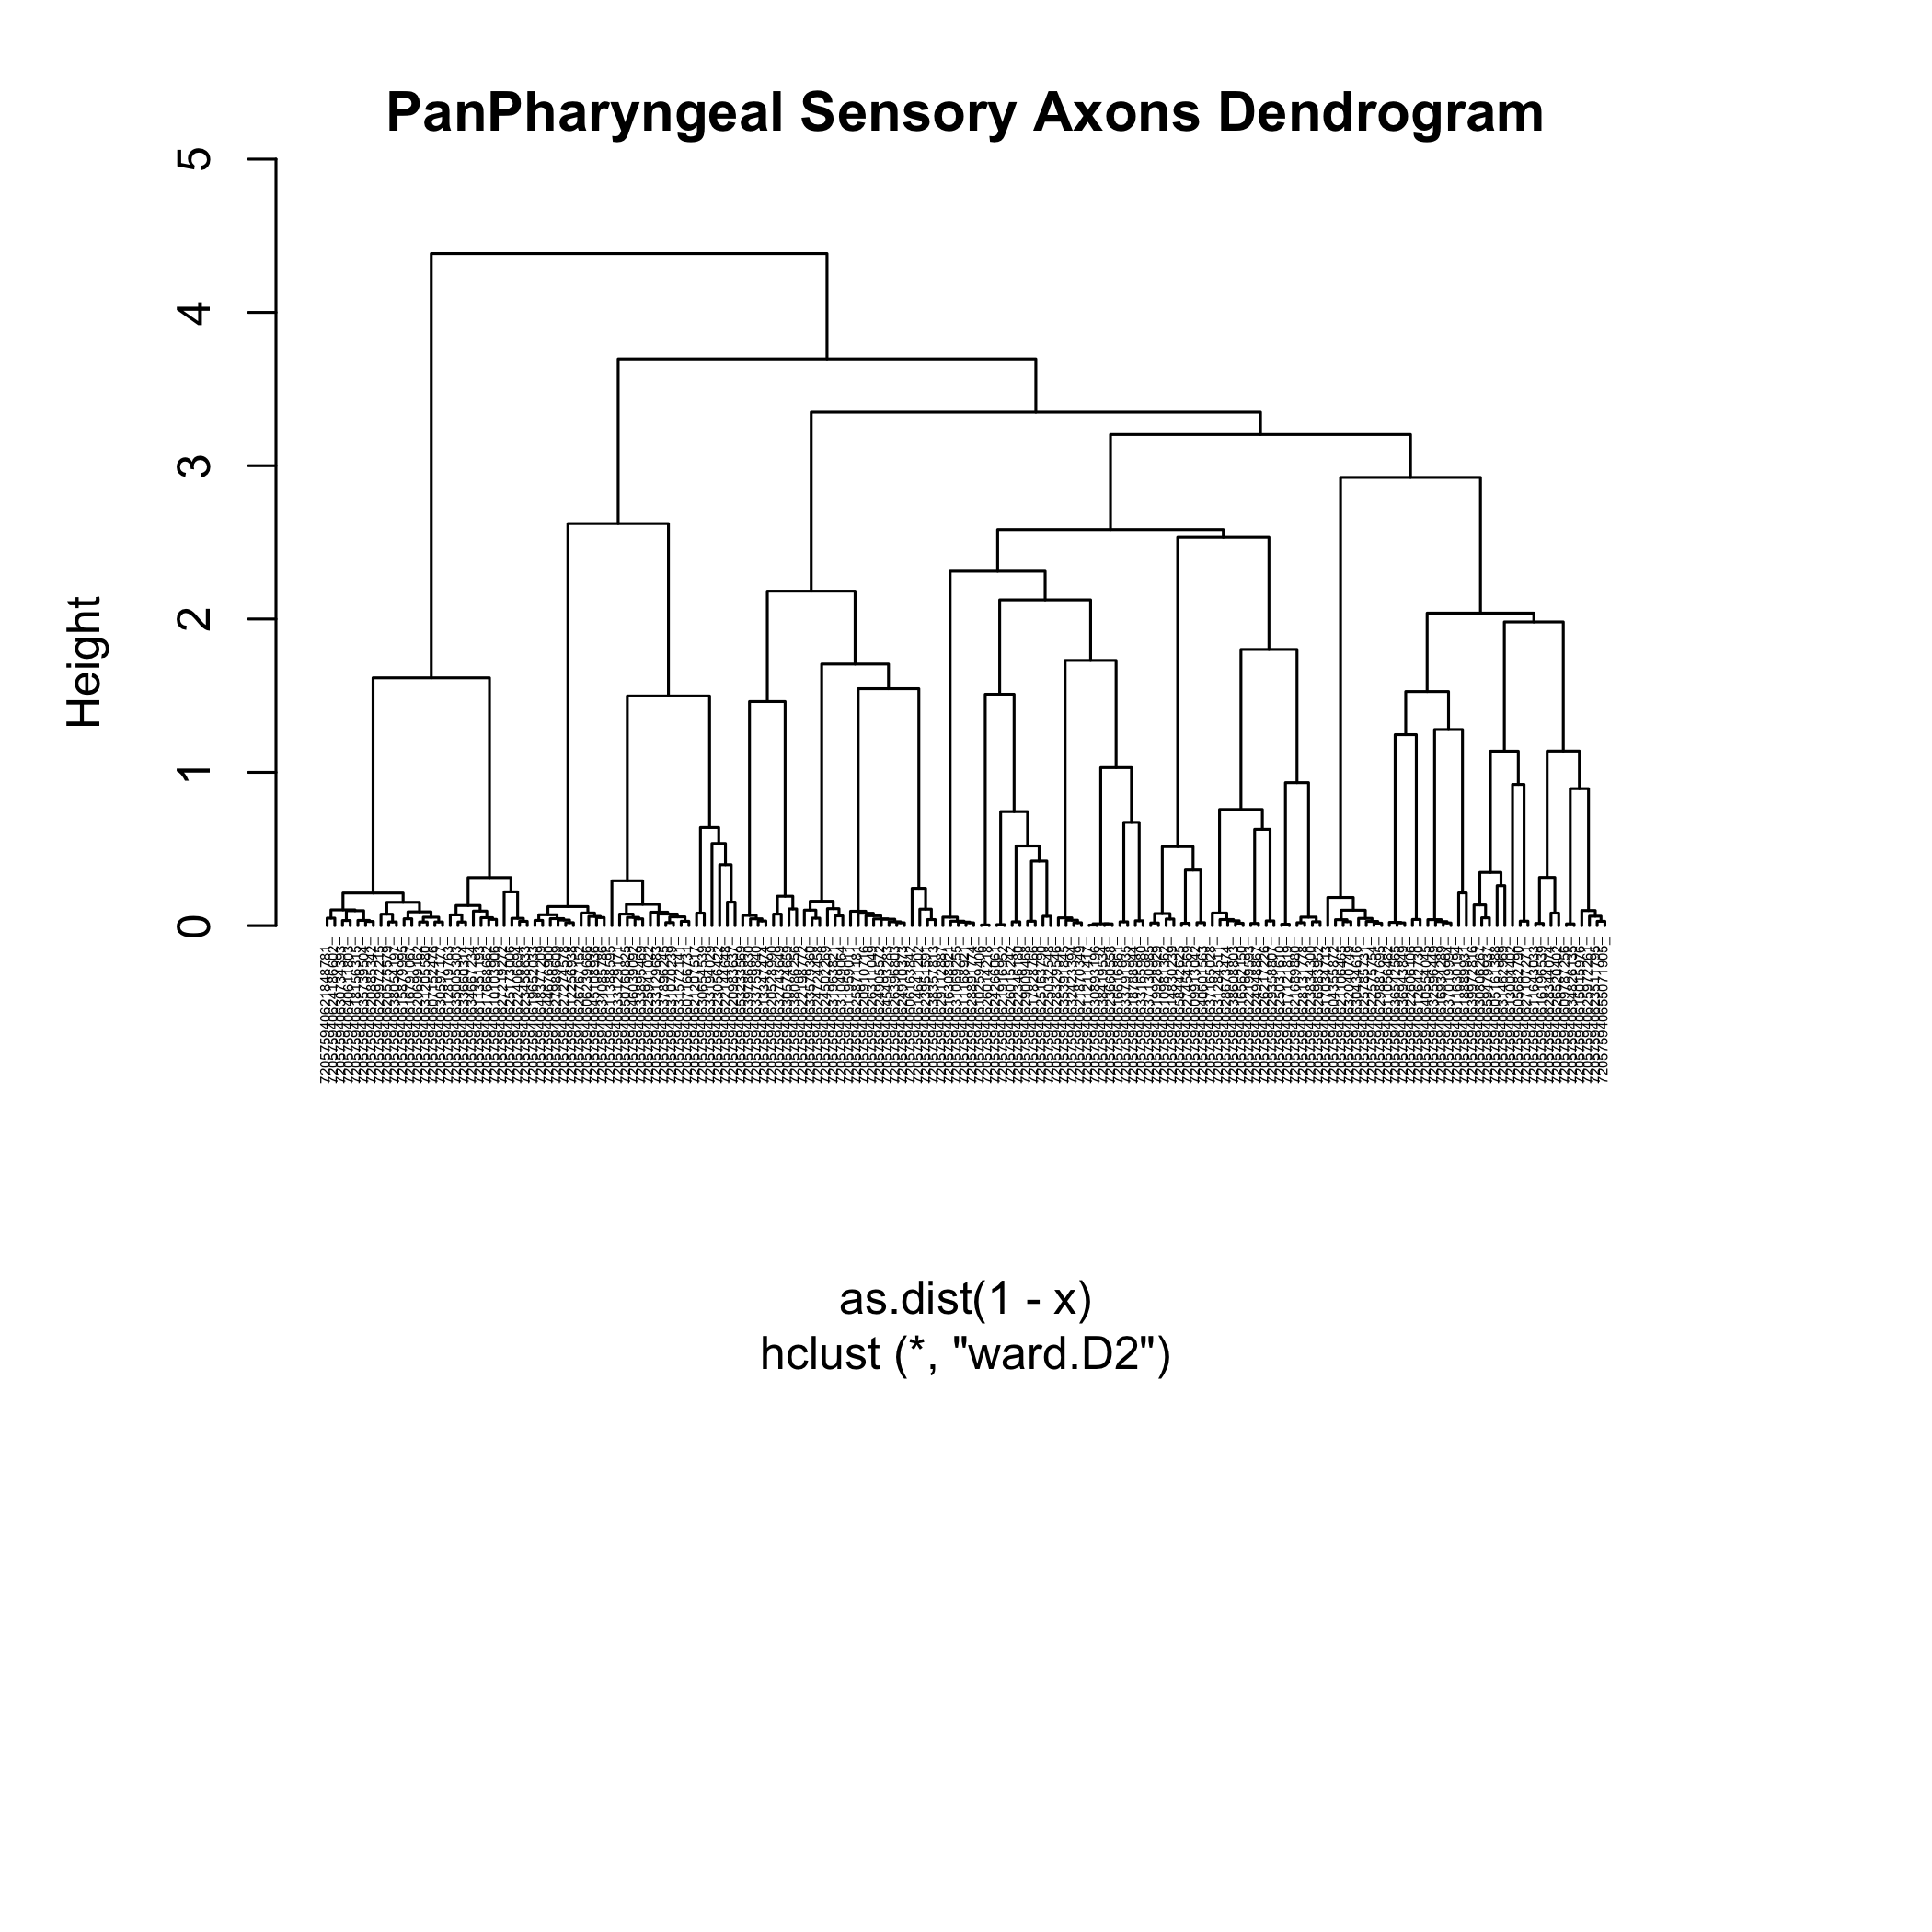

In [71]:
# Create combined labels: "id: nerve"
combined_labels <- paste(PanPharyngeal_meta$id, PanPharyngeal_meta$nerve, sep="_")


par(mar = c(15, 5, 4, 5), xpd = TRUE)
plot(hc,
     labels = combined_labels,
     hang = -0.01,
     cex = 0.3,
     main = "PanPharyngeal Sensory Axons Dendrogram")
dev.off()

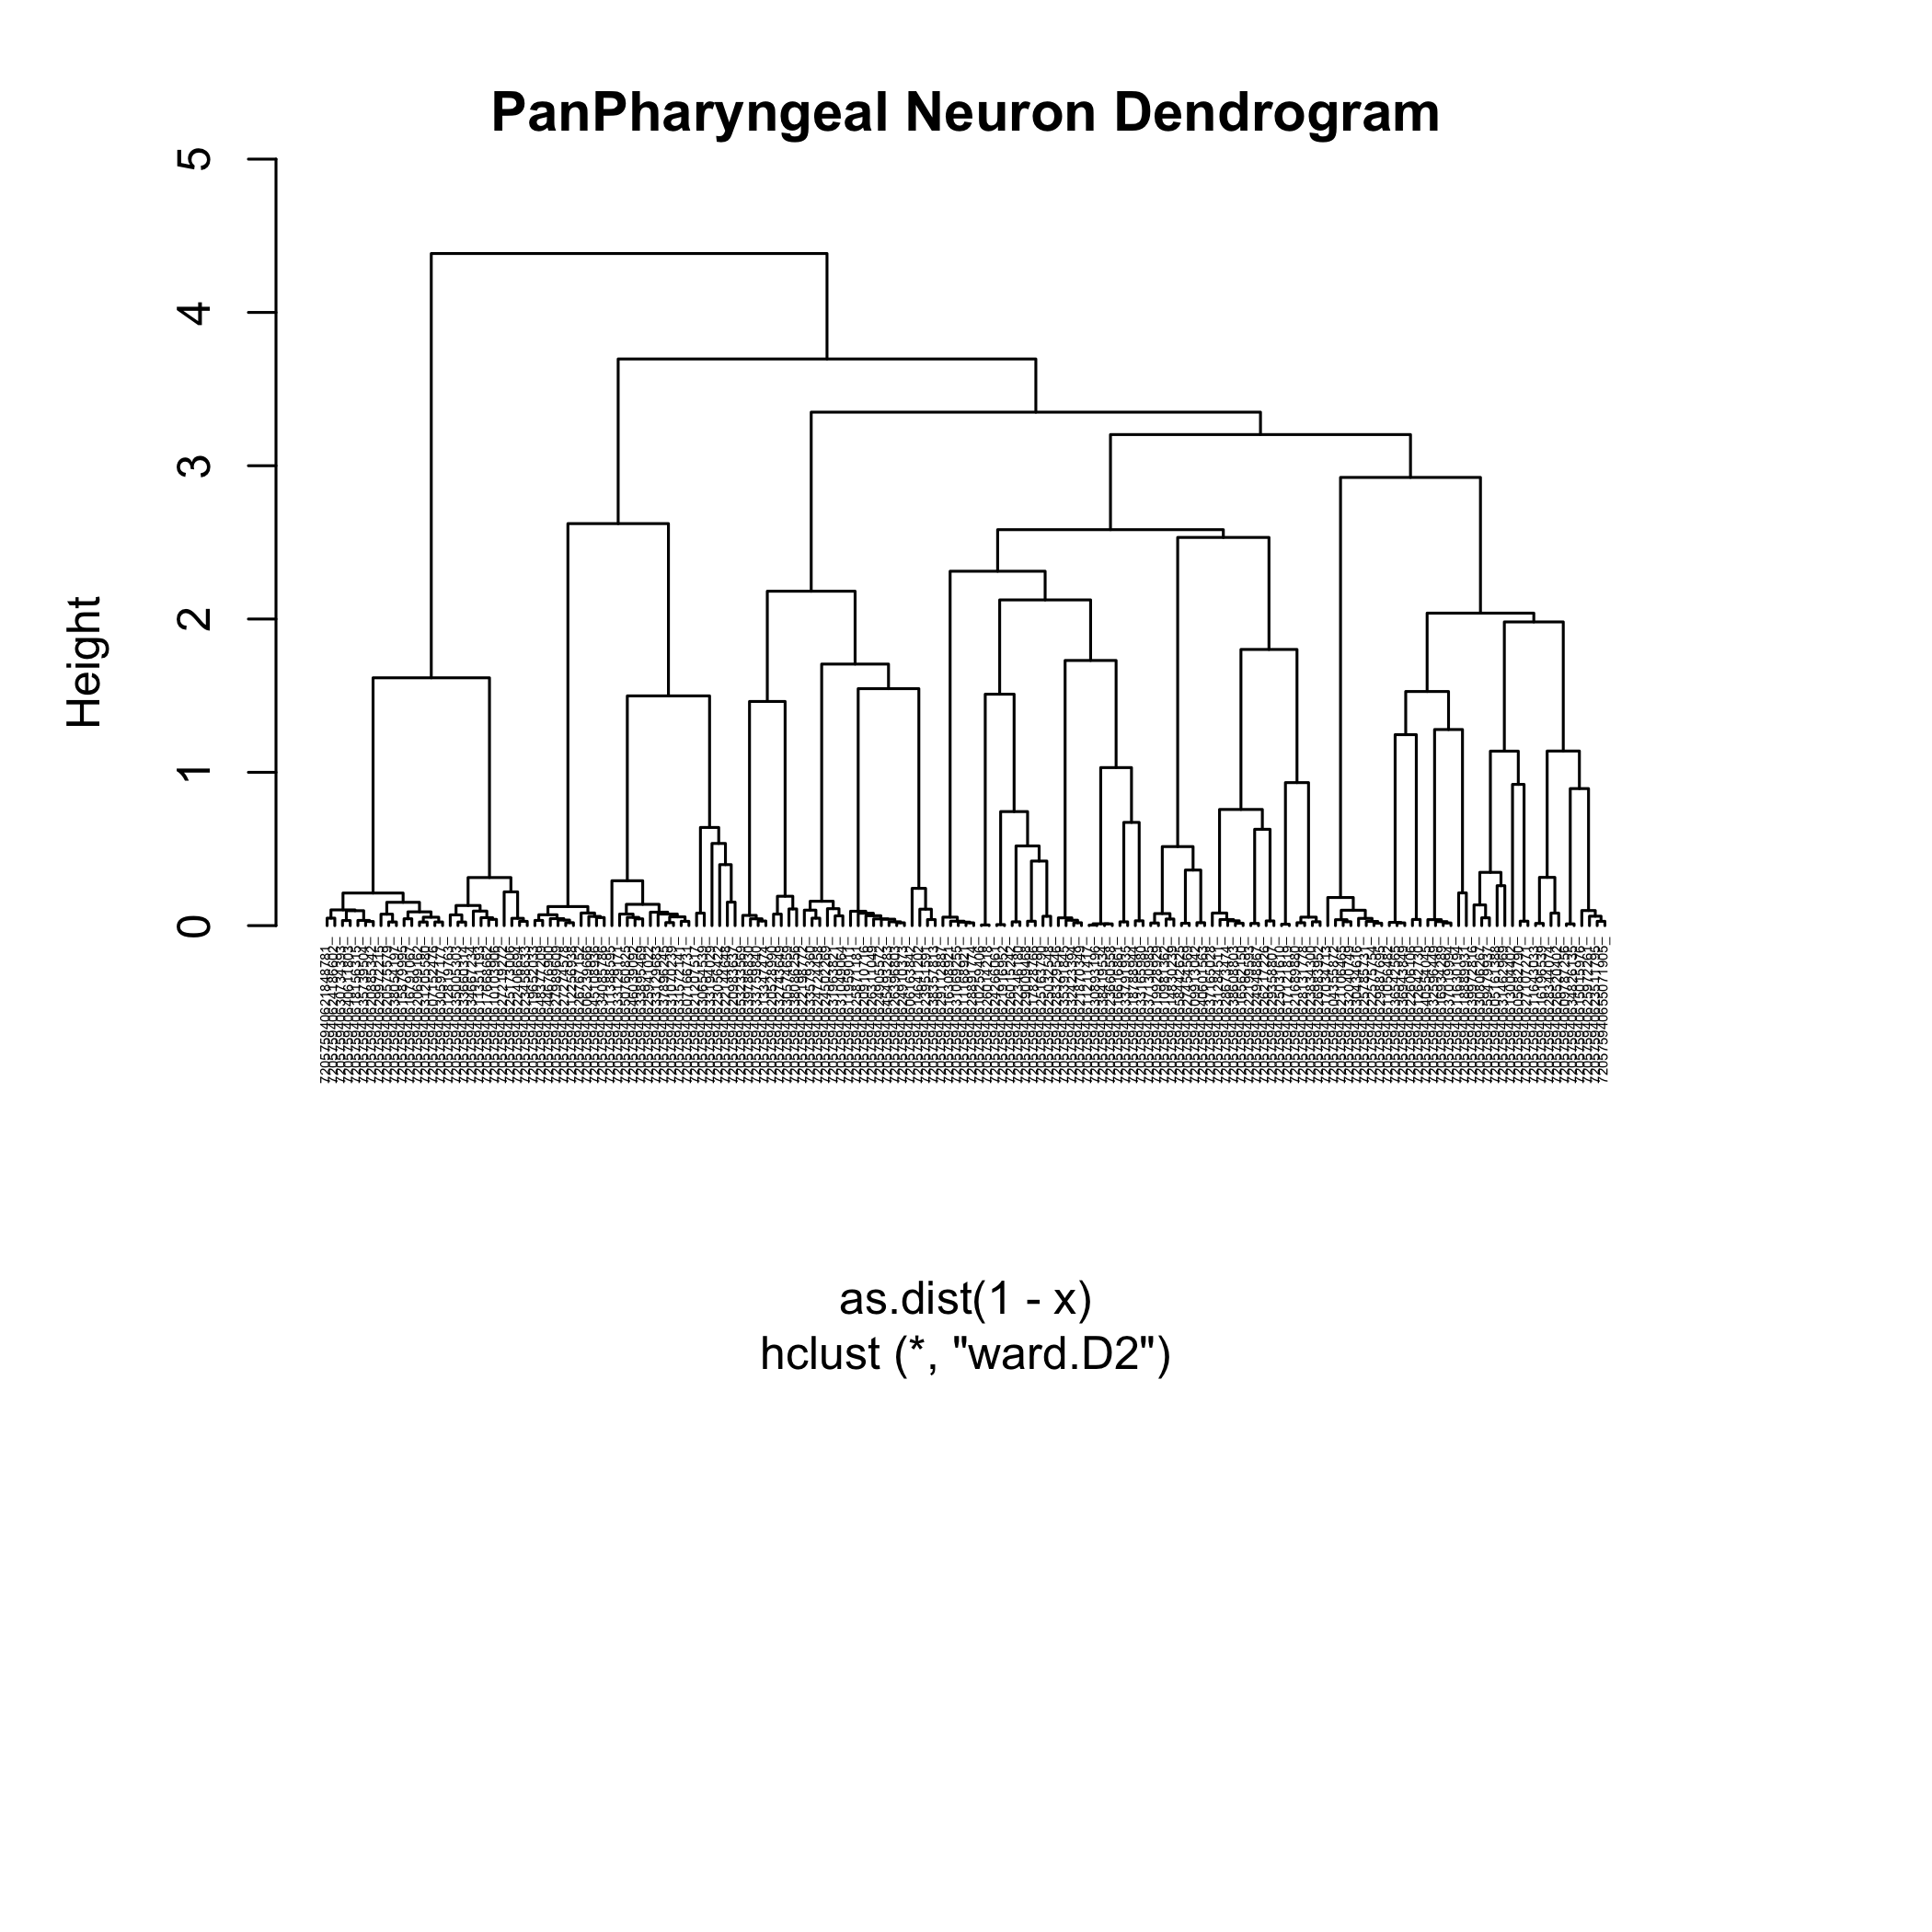

In [72]:
# Plot inline in your notebook at 300 dpi with similar margin settings
options(repr.plot.res = 300)
par(mar = c(15, 5, 4, 5), xpd = TRUE)
plot(
    hc,
    labels = combined_labels,
    hang = -0.01,
    cex = 0.3,
    main = "PanPharyngeal Neuron Dendrogram"
)

In [73]:
PanPharyngeal_meta <- left_join(PanPharyngeal_meta, aPhN_PhN %>% select(id, nerve), by = "id")


In [74]:
combined_labels <- paste(PanPharyngeal_meta$id, PanPharyngeal_meta$nerve, sep=": ")


### Note
The following root IDs (marked with “?”) were incorrectly assigned as aPhN1 in FAFB v783. We used connectivity-based clustering to reclassify them as aPhN2. This analysis primarily served to cluster these IDs for Figure 1D in our study.

pdf 
  2

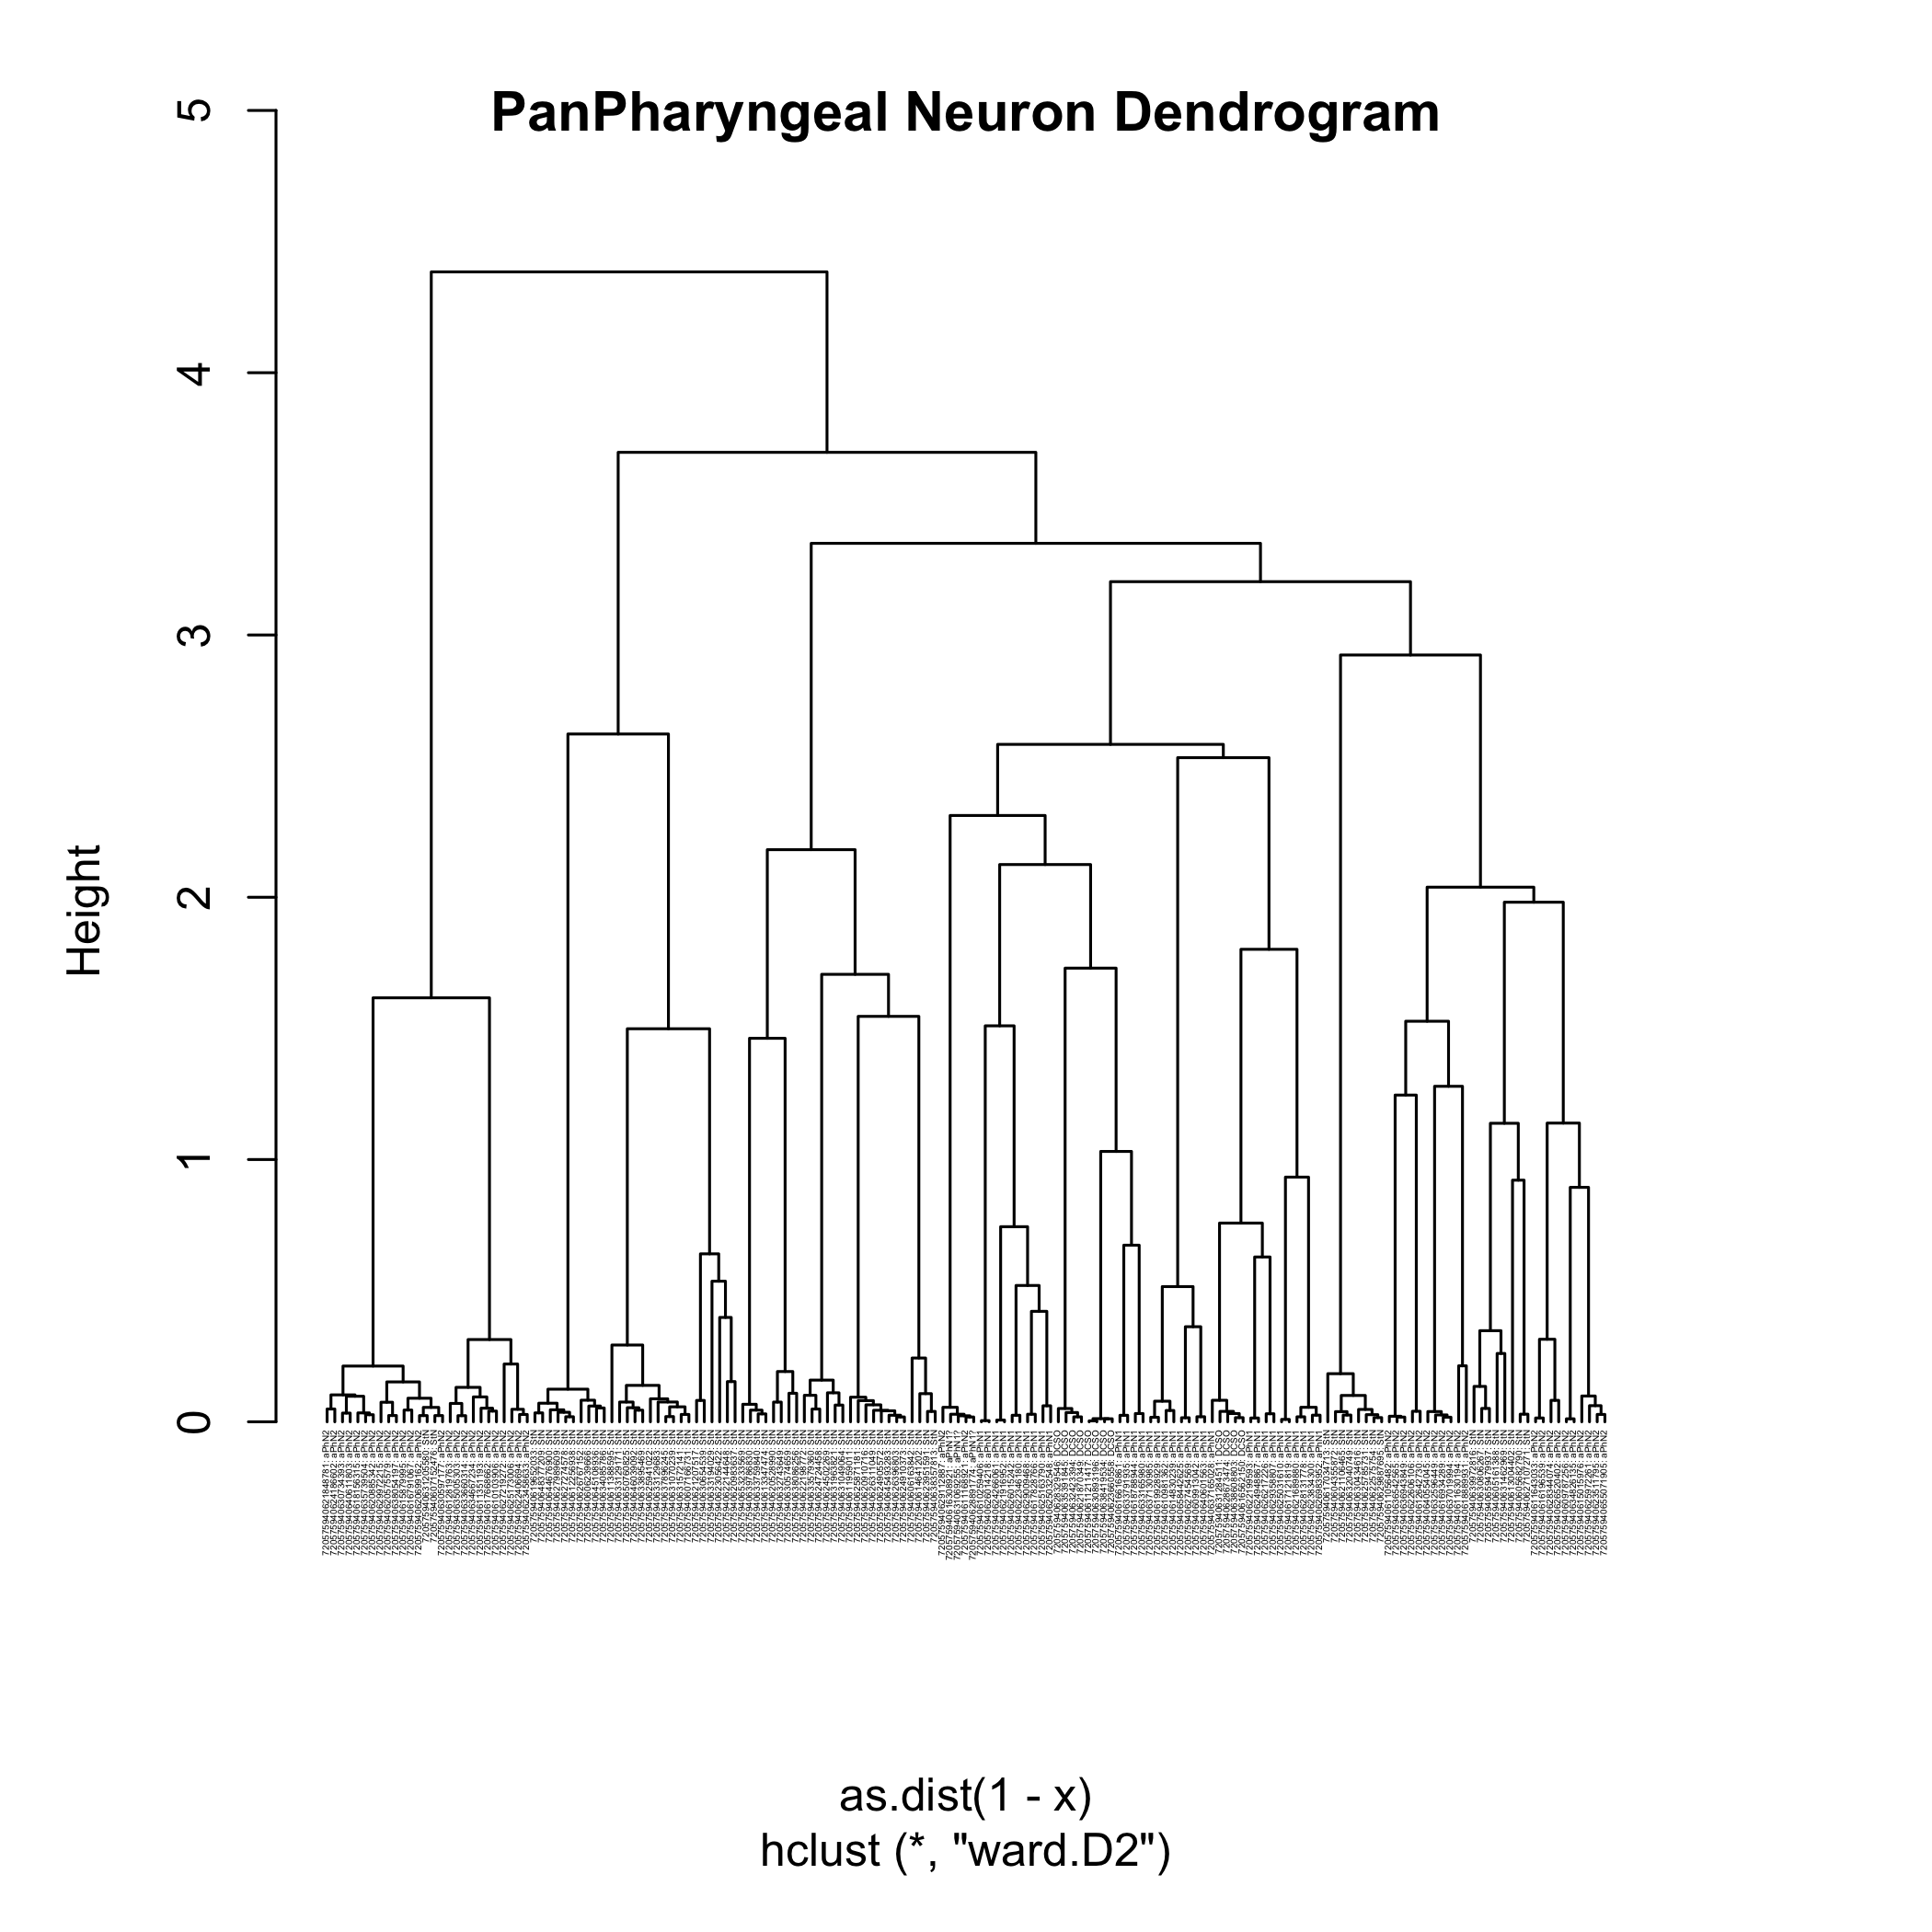

In [75]:
pdf(paste0(PATH_output, "aPhN_PhN_dendrogram_wardd2.pdf"), width = 10, height = 6)
par(mar = c(6, 5, 4, 5), xpd = TRUE)
plot(hc,
     labels = combined_labels,
     hang = -0.01,
     cex = 0.2,
     main = "PanPharyngeal Sensory Axons Dendrogram")
dev.off()

options(repr.plot.res = 300)
par(mar = c(6, 5, 4, 5), xpd = TRUE)
plot(
    hc,
    labels = combined_labels,
    hang = -0.01,
    cex = 0.2,
    main = "PanPharyngeal Neuron Dendrogram"
)


pdf 
  2

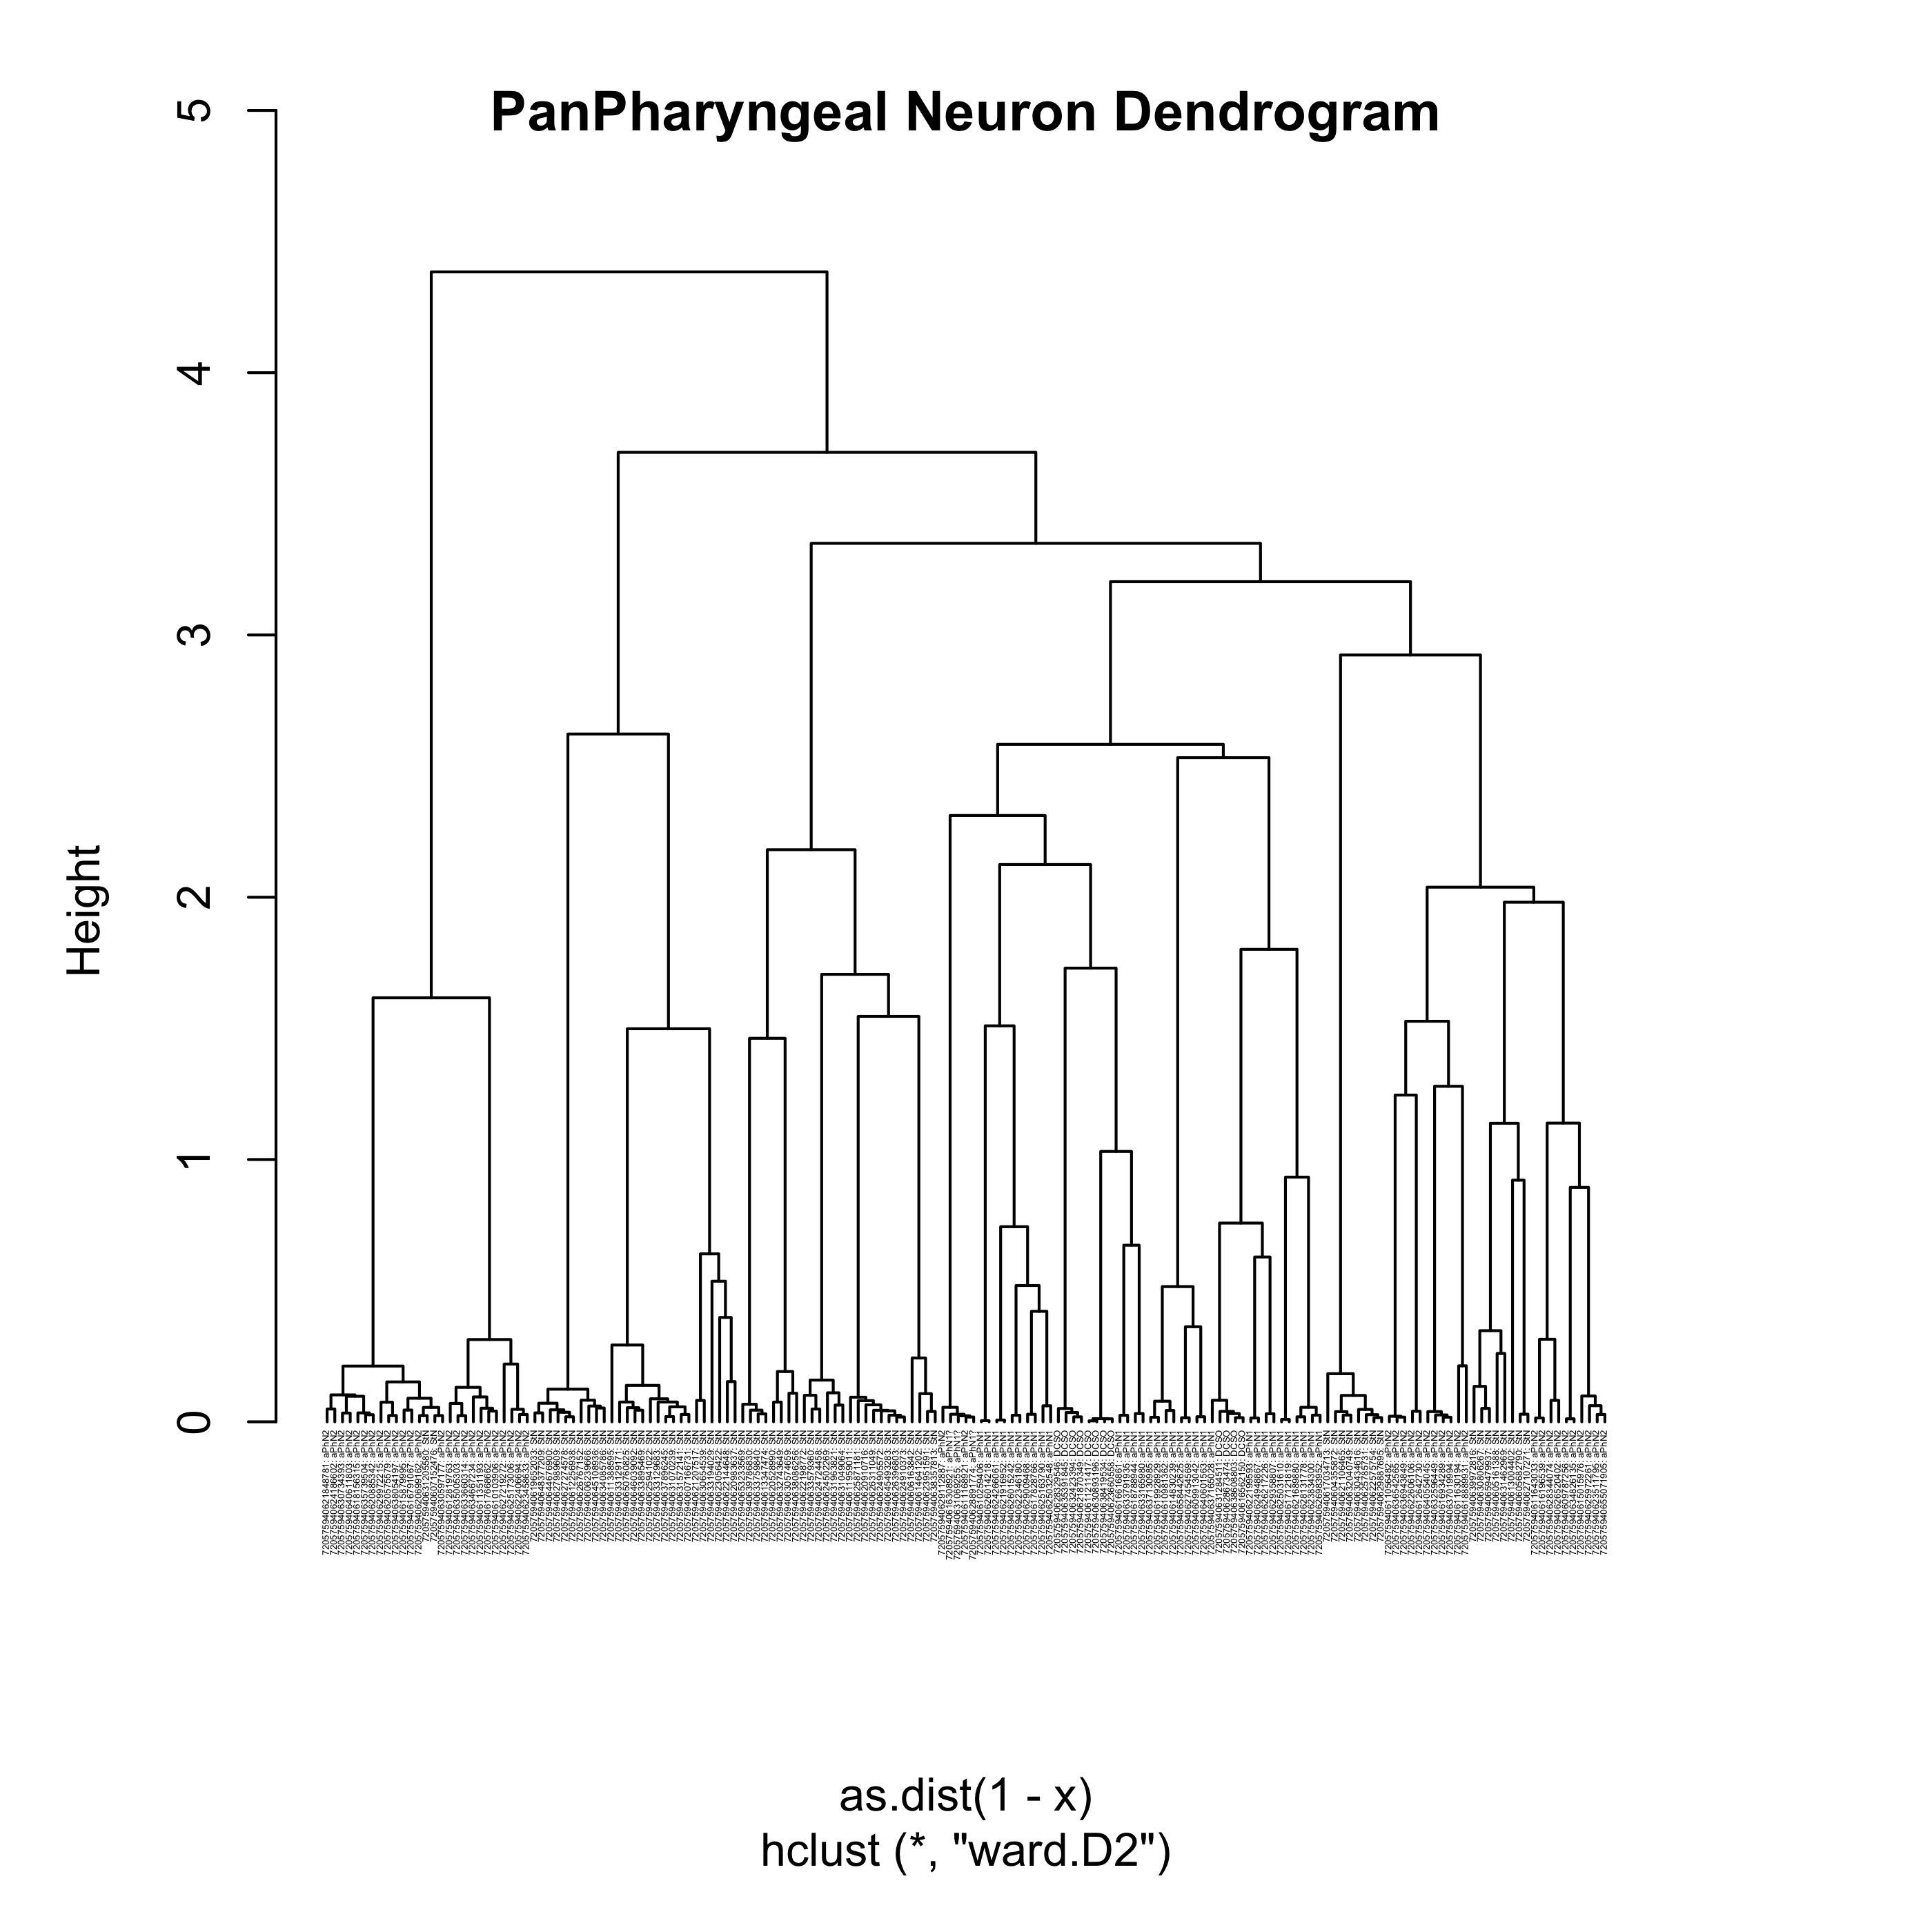

In [81]:
svg(paste0(PATH_output, "aPhN_PhN_dendrogram_wardd2.svg"), width = 10, height = 4)
par(mar = c(6, 5, 4, 5), xpd = TRUE)
plot(hc,
     labels = combined_labels,
     hang = -0.01,
     cex = 0.2,
     main = "PanPharyngeal Sensory Axons Dendrogram")
dev.off()

options(repr.plot.res = 400)
par(mar = c(6, 5, 4, 5), xpd = TRUE)
plot(
    hc,
    labels = combined_labels,
    hang = -0.01,
    cex = 0.2,
    main = "PanPharyngeal Neuron Dendrogram"
)
